# Madrid Houding Demo, 2021 version on CP4D Cloud

1. Data Loading & Preparations
2. Feature Engineering
3. Exploration (Plots)
4. Model Training
5. Evaluation
6. Model Deployment with `WML`

---

## Installing Libraries

Notice how it is possible to use `!pip install` to install most common python packages. Here we install `folium` to later plot maps.

In [125]:
%%capture INSTALL_FOLIUM
!pip install folium

In [126]:
import folium

In [127]:
import numpy as np
import pandas as pd
import sklearn
import xgboost as xgb

## 1 - Data Preparations

Currently, the data is loaded from my Cloud Object Storage (**COS**).
The notebook runs just fine, but if you want you can load the files from your own COS, as a exercice.

**(?)** - Do you want to use the data from your own **COS** (not necessary)?

1. Delete the content of the cell below, but keep the cell active. The next steps will generate the correct code.
2. Click the **Find and Add Data** button, on the upper right, the zeros and ones.
3. From **Files**, find `madrid_houses_v5.csv` and, **Insert to code > Pandas Dataframe**
4. Rename the generated variable name for the DataFrame to `madrid_data`

In [128]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_01fa29576c1949bf8bf19f9e93a1ba4a = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='5utcRKjAP6oicRlTREMU5XceyqyvS6dZFdUQZwssBR0V',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_01fa29576c1949bf8bf19f9e93a1ba4a.get_object(Bucket='madridhousingdemo2020-donotdelete-pr-imjaqeqxyrmemj',Key='madrid_houses_v5.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

madrid_data = pd.read_csv(body)
madrid_data.head()


ad_id     price  region_level2_id      lat      lng  \
0  141537319.0  550000.0              28.0  40.4040 -3.69258   
1  141129777.0   84999.0              28.0  40.4212 -3.61754   
2  141321296.0  159999.0              28.0  40.4226 -3.64750   
3  142917234.0  515000.0              28.0  40.4429 -3.71124   
4  141506865.0  115000.0              28.0  40.3796 -3.73910   

           create_date property property_state  district_id   mts2  ...  \
0  22/02/2017 13:15:54     Flat       VeryGood        671.0  178.0  ...   
1  17/01/2017 19:37:03     Flat            NaN        676.0   60.0  ...   
2  02/02/2017 18:53:29     Flat            NaN        685.0   67.0  ...   
3   15/06/2017 7:43:11     Flat           Good        177.0  139.0  ...   
4  20/02/2017 13:00:42     Flat            NaN        171.0   56.0  ...   

   pista-tenis sauna  piscina-comunitaria  puerta-blindada  terraza lavadora  \
0            0     0                    0                0        1        0   
1            0     0                    0                0        0        0   
2            0     0                    0                0        0        0   
3            0     0                    0                0        0        0   
4            0     0                    0                1        0        0   

   serv-porteria  zona-infantil  cocina-office parking-comunitario  
0              1              0              0                   0  
1              0              0              0                   0  
2              0              0              0                   0  
3              0              0              0                   0  
4              0              0              0                   0  

[5 rows x 92 columns]

In [129]:
madrid_with_price = madrid_data[ (madrid_data["price"] > 30.000) & (madrid_data["mts2"] > 30.0) ]
madrid_with_price.head()

ad_id     price  region_level2_id      lat      lng  \
0  141537319.0  550000.0              28.0  40.4040 -3.69258   
1  141129777.0   84999.0              28.0  40.4212 -3.61754   
2  141321296.0  159999.0              28.0  40.4226 -3.64750   
3  142917234.0  515000.0              28.0  40.4429 -3.71124   
4  141506865.0  115000.0              28.0  40.3796 -3.73910   

           create_date property property_state  district_id   mts2  ...  \
0  22/02/2017 13:15:54     Flat       VeryGood        671.0  178.0  ...   
1  17/01/2017 19:37:03     Flat            NaN        676.0   60.0  ...   
2  02/02/2017 18:53:29     Flat            NaN        685.0   67.0  ...   
3   15/06/2017 7:43:11     Flat           Good        177.0  139.0  ...   
4  20/02/2017 13:00:42     Flat            NaN        171.0   56.0  ...   

   pista-tenis sauna  piscina-comunitaria  puerta-blindada  terraza lavadora  \
0            0     0                    0                0        1        0   
1            0     0                    0                0        0        0   
2            0     0                    0                0        0        0   
3            0     0                    0                0        0        0   
4            0     0                    0                1        0        0   

   serv-porteria  zona-infantil  cocina-office parking-comunitario  
0              1              0              0                   0  
1              0              0              0                   0  
2              0              0              0                   0  
3              0              0              0                   0  
4              0              0              0                   0  

[5 rows x 92 columns]

In [130]:
print("A total of ", madrid_with_price.count()[0], " houses are available in the data set.")

A total of  16161  houses are available in the data set.


## Heatmap of Data with Folium

In [131]:
import folium

cybele_palace = (40.418906, -3.692084)

lat_lng_list = list( zip( list(madrid_with_price.lat), list(madrid_with_price.lng) ) )
house_density = [ (lat,lng,0.3) for (lat,lng) in lat_lng_list ]
centre_madrid = cybele_palace

from folium.plugins import HeatMap

map_with_houses = folium.Map(centre_madrid, tiles='stamentoner', zoom_start=11)

HeatMap(house_density).add_to(map_with_houses)
map_with_houses

## A Classic Linear Regression on the size of property to predict the price

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [132]:
import numpy as np
from sklearn import datasets, linear_model

x = madrid_with_price["mts2"].to_frame()
y = madrid_with_price["price"].to_frame()

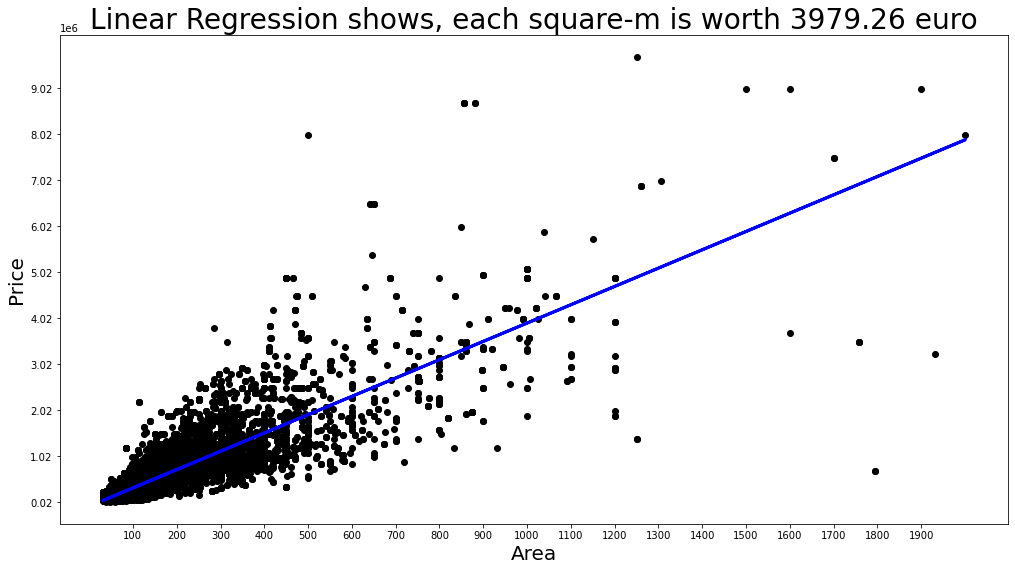

In [133]:
%matplotlib inline  
import matplotlib.pyplot as plt

regr = linear_model.LinearRegression()
regr.fit(x, y)

# plot it as in the example at http://scikit-learn.org/
plt.figure(figsize=(17, 9))
title = "Linear Regression shows, each square-m is worth {0:.2f} euro".format( regr.coef_.flatten()[0] )
plt.title(title, fontsize=28) 
plt.scatter(x.values, y.values,  color='black')
plt.xticks((np.arange(100,2000,100)))
plt.yticks((np.arange(20000,10000000,1000000)))
plt.xlabel('Area', fontsize=20)
plt.ylabel('Price', fontsize=20)
plt.plot(x, regr.predict(x), color='blue', linewidth=3)

plt.show()

In [134]:
y_true = madrid_with_price["price"].to_frame()
y_pred = regr.predict(madrid_with_price["mts2"].to_frame())

In [135]:
regression_MSE = sklearn.metrics.mean_squared_error(y_true, y_pred)
rmse_lm = np.sqrt(regression_MSE)

In [136]:
print(" The RSME for the Linear Model is {}".format(rmse_lm))

 The RSME for the Linear Model is 374323.27660223434


## 2. Feature Engineering

### Feature Engineering - Add `distance_to_centre` as new Column

In [137]:
import geopy
from geopy.distance import great_circle

puerta_del_sol = (40.416920, -3.703479)

def distance_to_puerta_del_sol(lat, lng):
    global puerta_del_sol
    return great_circle( (lat,lng), puerta_del_sol ).km

cybele_palace = (40.418906, -3.692084)
print( "The distance (KM) from Cybele Palace, to Puerta del Sol is {0:.2f} KM".format( distance_to_puerta_del_sol(*cybele_palace) ) )

The distance (KM) from Cybele Palace, to Puerta del Sol is 0.99 KM


In [138]:
distance_to_centre_series = madrid_with_price.apply( lambda x : distance_to_puerta_del_sol(x.lat , x.lng) , axis=1)
distance_to_centre_df = distance_to_centre_series.to_frame(name="distance_to_centre")
distance_to_centre_df.head(5)

distance_to_centre
0            1.707470
1            7.290744
2            4.780775
3            2.962595
4            5.130278

In [139]:
madrid_with_centre = madrid_with_price.join(distance_to_centre_df)
madrid_with_centre[["ad_id","price","lat","lng","create_date","distance_to_centre","mts2"]].head(5)

ad_id     price      lat      lng          create_date  \
0  141537319.0  550000.0  40.4040 -3.69258  22/02/2017 13:15:54   
1  141129777.0   84999.0  40.4212 -3.61754  17/01/2017 19:37:03   
2  141321296.0  159999.0  40.4226 -3.64750  02/02/2017 18:53:29   
3  142917234.0  515000.0  40.4429 -3.71124   15/06/2017 7:43:11   
4  141506865.0  115000.0  40.3796 -3.73910  20/02/2017 13:00:42   

   distance_to_centre   mts2  
0            1.707470  178.0  
1            7.290744   60.0  
2            4.780775   67.0  
3            2.962595  139.0  
4            5.130278   56.0

## 3. Exploration (Plots)

### Feature Engineering - Lat / Long, & Metro Stations in Madrid

We can add more features, like the distance to the closest metro station

![](https://s-media-cache-ak0.pinimg.com/originals/eb/8d/e5/eb8de521b72848827903a35a2e9ceca9.jpg)

## Load your own Data?

Currently, the data is loaded from my Cloud Object Storage (**COS**).
The notebook runs just fine, but if you want you can load the files from your own COS, as a exercice.

**(?)** - Do you want to use the data from your own **COS** (not necessary)?

1. Delete the content of the cell below, but keep the cell active. The next steps will generate the correct code.
2. Click the **Find and Add Data** button, on the upper right, the zeros and ones.
3. From **Files**, find `unique_metro_v5.csv` and, **Insert to code > Pandas Dataframe**
4. Rename the generated variable name for the DataFrame to `metros_in_madrid`

In [140]:
body = client_01fa29576c1949bf8bf19f9e93a1ba4a.get_object(Bucket='madridhousingdemo2020-donotdelete-pr-imjaqeqxyrmemj',Key='unique_metro_v5.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

metros_in_madrid = pd.read_csv(body)
metros_in_madrid.head()


0             Pacífico (Madrid Metro)   40.40126  -3.6751312000000005
0  1  Sierra de Guadalupe (Madrid Metro)  40.382164            -3.624719
1  2               Atocha (Madrid Metro)  40.408851            -3.692484
2  3             Portazgo (Madrid Metro)  40.392661            -3.658679
3  4               Bilbao (Madrid Metro)  40.429054            -3.702182
4  5         Antón Martín (Madrid Metro)  40.412468            -3.699369

In [141]:
metros_in_madrid.columns = ["id","station","latitude","longitude"]
metros_in_madrid = metros_in_madrid[ metros_in_madrid["latitude"] > 39.5 ]
metros_in_madrid.head()

id                             station   latitude  longitude
0   1  Sierra de Guadalupe (Madrid Metro)  40.382164  -3.624719
1   2               Atocha (Madrid Metro)  40.408851  -3.692484
2   3             Portazgo (Madrid Metro)  40.392661  -3.658679
3   4               Bilbao (Madrid Metro)  40.429054  -3.702182
4   5         Antón Martín (Madrid Metro)  40.412468  -3.699369

### Again, we can use Folium to make pretty maps of the Metro Stations in Madrid

In [142]:
import folium

map_osm = folium.Map(location=[np.mean(metros_in_madrid.latitude), np.mean(metros_in_madrid.longitude)])
for i in range(metros_in_madrid.id.count()):
    row = metros_in_madrid.iloc[i]
    folium.Marker([row.latitude, row.longitude]).add_to(map_osm)
    
map_osm

Zoom in to take a look at where the metros are.

### Determine distance from our favourite reference location to the nearest metro station
We do this by defining a function which uses the locations of all the metros, the call the functions with our favourite Cybele Palace location 

In [143]:
from sklearn.neighbors import DistanceMetric

dist = DistanceMetric.get_metric('haversine')

houses_gps = madrid_with_centre[["lat", "lng"]].values
metro_gps = metros_in_madrid[["latitude", "longitude"]].values

In [144]:
EARTH_RADIUS = 6371.009

haversine_distances = dist.pairwise(np.radians(houses_gps), np.radians(metro_gps) )
haversine_distances *= EARTH_RADIUS

In [145]:
madrid_with_centre["distance_to_metro"] = np.min(haversine_distances,axis=1) 

### Feature Engineering - Make Data more colorful, reflect certain aspect more prominent in the data
If we join the results of the distance calculation with the original data we can show the distance to a metro station

In [146]:
madrid_with_metro = madrid_with_centre.copy()
madrid_with_metro.head(3)

ad_id     price  region_level2_id      lat      lng  \
0  141537319.0  550000.0              28.0  40.4040 -3.69258   
1  141129777.0   84999.0              28.0  40.4212 -3.61754   
2  141321296.0  159999.0              28.0  40.4226 -3.64750   

           create_date property property_state  district_id   mts2  ...  \
0  22/02/2017 13:15:54     Flat       VeryGood        671.0  178.0  ...   
1  17/01/2017 19:37:03     Flat            NaN        676.0   60.0  ...   
2  02/02/2017 18:53:29     Flat            NaN        685.0   67.0  ...   

   piscina-comunitaria puerta-blindada  terraza  lavadora  serv-porteria  \
0                    0               0        1         0              1   
1                    0               0        0         0              0   
2                    0               0        0         0              0   

  zona-infantil  cocina-office  parking-comunitario  distance_to_centre  \
0             0              0                    0            1.707470   
1             0              0                    0            7.290744   
2             0              0                    0            4.780775   

  distance_to_metro  
0          0.169548  
1          0.482161  
2          0.514768  

[3 rows x 94 columns]

## 4. Model Training

## Convert Categories with Factorization/One-Hot-Encode

In [147]:
COLUMNS_TO_ENCODE = ["property_state", "district"]

In [148]:
madrid_with_metro_encoded = madrid_with_metro.copy()

In [149]:
label_mapping = {}

for column in COLUMNS_TO_ENCODE:
    madrid_with_metro_encoded[column], label_mapping[column] = pd.factorize(madrid_with_metro[column])

In [150]:
label_mapping

{'property_state': Index(['VeryGood', 'Good', 'AlmostNew', 'ToMakeImprovements', 'Reformed'], dtype='object'),
 'district': Index(['Arganzuela', 'San Blas', 'Ciudad Lineal', 'Chamberí', 'Carabanchel',
        'Chamartín', 'Usera', 'Centro', 'Moncloa', 'Barajas',
        'Puente de Vallecas', 'Fuencarral', 'Tetuán', 'Moratalaz', 'Latina',
        'Retiro', 'Salamanca', 'Villa de Vallecas', 'Hortaleza', 'Villaverde',
        'Vicálvaro'],
       dtype='object')}

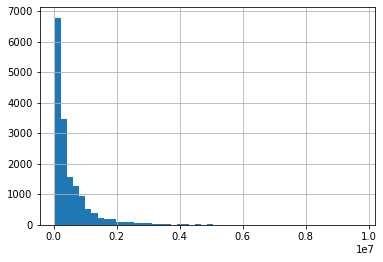

In [151]:
%matplotlib inline

_ = madrid_with_metro_encoded.price.hist(bins=50,)

In [152]:
madrid_with_metro_encoded['log_price'] = np.log( madrid_with_metro_encoded.price )

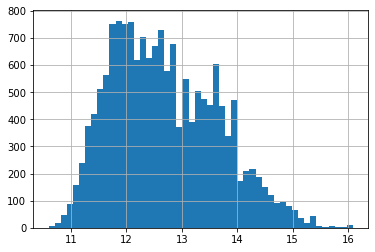

In [153]:
%matplotlib inline

_ = madrid_with_metro_encoded.log_price.hist(bins=50,)

In [154]:
from sklearn.model_selection import train_test_split, KFold

FEATURE_COLUMNS = ["property_state", "distance_to_centre", "distance_to_metro", "mts2"]

x_train, x_test, y_train, y_test = train_test_split(madrid_with_metro_encoded[FEATURE_COLUMNS], madrid_with_metro_encoded["log_price"])

## XGBoost Training

https://xgboost.readthedocs.io/en/latest/parameter.html

In [155]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test)

params = {
    'objective' : 'reg:linear',
    'tree_method':'auto',
    'min_child_weight' : 2,
    'eta' : 0.2,
    'gamma': 0,
    'max_depth': 5,
    'silent': 1,
    'nthread' : 1,
    #'colsample_bytree': 0.7,
    #'subsample':0.8,
}

hist = xgb.cv(params, dtrain, nfold=3, as_pandas=True, num_boost_round=30, verbose_eval=5, early_stopping_rounds=50)

[0]	train-rmse:9.79364+0.00591888	test-rmse:9.79394+0.011605
[5]	train-rmse:3.23539+0.00172999	test-rmse:3.23568+0.00910807
[10]	train-rmse:1.11268+0.000444984	test-rmse:1.11426+0.00747048
[15]	train-rmse:0.475369+0.00167817	test-rmse:0.481678+0.00700947
[20]	train-rmse:0.325821+0.00268025	test-rmse:0.336414+0.00582473
[25]	train-rmse:0.294009+0.0027199	test-rmse:0.30728+0.00405398
[29]	train-rmse:0.281359+0.00269854	test-rmse:0.29622+0.00272644


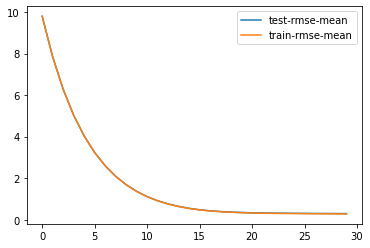

In [156]:
hist.plot(y=["test-rmse-mean", "train-rmse-mean"])

In [157]:
%%time
bst = xgb.train(params, dtrain, num_boost_round=30, verbose_eval=5)

CPU times: user 131 ms, sys: 0 ns, total: 131 ms
Wall time: 134 ms


In [158]:
y_preds = bst.predict(dtest)

In [159]:
y_preds_exp = np.exp(y_preds)
y_true_exp = np.exp(y_test)

mse_xgb = sklearn.metrics.mean_squared_error(y_preds_exp, y_true_exp)
rmse_xgb = np.sqrt(mse_xgb)
print(rmse_xgb)

264487.24483696604


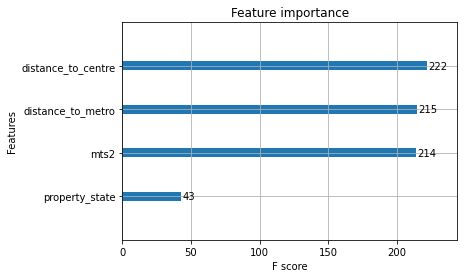

In [160]:
_ = xgb.plot_importance(bst)

### XGBoost Version Check - need to match the deployment environment

In [161]:
xgb.__version__

'0.90'

## 5. Evaluation

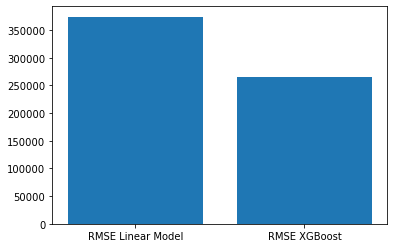

In [162]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(2)
money = [rmse_lm, rmse_xgb]

fig, ax = plt.subplots()

plt.bar(x, money)
plt.xticks(x, ('RMSE Linear Model', 'RMSE XGBoost'))
plt.show()

## Use Watson Machine Learning Service - Store and Deploy the XGBoost Model

1. (Create &) Store the `API Key` from your [IAM API Keys](https://cloud.ibm.com/docs/account?topic=account-userapikey#manage-user-keys) 
3. With the correct [Endpoint](https://fra02.console.cloud.ibm.com/apidocs/machine-learning), and the `API Key` authenticate with the WML Client

See [Watson Machine Learning](https://fra02.console.cloud.ibm.com/apidocs/machine-learning) Documentation for more details,
and [Space management.ipynb](https://github.com/IBM/watson-machine-learning-samples/blob/master/notebooks/python_sdk/instance-management/Space%20management.ipynb) for examples on Space Management.

For a example of a deployment with the September 2020 release of WML see the [SciKit Learn Example](https://github.com/IBM/watson-machine-learning-samples/blob/master/notebooks/python_sdk/deployments/scikit-learn/Use%20scikit-learn%20to%20recognize%20hand-written%20digits.ipynb)


---

**(!)** Make sure to replace the `API_KEY` with your own key

![create_api_key](https://gitlab.com/whendrik/madrid-workshop/-/raw/master/images/create_api_key.gif)


In [163]:
API_KEY = "DmUk9dL8flEjlVrPsZYN3WcPy-Y7dYo8VY6ujsvgmWOx"

In [164]:
api_key = API_KEY
location = 'us-south'

In [165]:
wml_credentials = {
    "apikey": api_key,
    "url": 'https://' + location + '.ml.cloud.ibm.com'
}

In [166]:
%%capture pip
!pip install -U ibm-watson-machine-learning

In [167]:
from ibm_watson_machine_learning import APIClient

client = APIClient(wml_credentials)

In [168]:
client

## 6. Model Deployment

### Set the Space_ID

(?) No Space yet? - You can manually create one, by going to the `Deployment Spaces` in the menu. 

**(!)** Make sure to change `space_id` with your own space id


![create_deployment_space](https://gitlab.com/whendrik/madrid-workshop/-/raw/master/images/create_deployment_space.gif)

In [169]:
space_id = 'f17c1943-d0dd-4b1b-ba72-7e1868b609ae'

In [170]:
client.spaces.list(limit=10)

------------------------------------  -----------------------------------------------------------  ------------------------
ID                                    NAME                                                         CREATED
958da19a-2dce-4b6c-a20c-51d2c36ac5b1  openscale-express-path-af447f9f-8976-4deb-b5e4-15606f9aa4e4  2021-03-10T12:10:21.478Z
5c9156cf-7deb-4787-8ba2-6276d69aa468  ModelOps Space                                               2021-01-05T14:04:44.780Z
f22c6b17-b0e0-4aeb-8482-0feee522429c  openscale-express-path-f0aff12f-bb7e-4c3f-8f2f-600b5926f5ed  2020-11-17T19:52:56.337Z
f17c1943-d0dd-4b1b-ba72-7e1868b609ae  Madrid-PAID-space                                            2020-10-14T18:37:04.690Z
e8d1e117-04b4-4153-a5fd-6485e3435814  KNOWIS                                                       2020-10-08T10:39:58.965Z
f7535d29-8c83-4d09-b003-7de5c8ad559a  myspaceduringtheworkshop                                     2020-10-07T13:12:54.193Z
dd60b719-e79b-4dd2-be23-3

In [171]:
client.set.default_space(space_id)

'SUCCESS'

In [172]:
client.software_specifications.list()

-----------------------------  ------------------------------------  ----
NAME                           ASSET_ID                              TYPE
default_py3.6                  0062b8c9-8b7d-44a0-a9b9-46c416adcbd9  base
pytorch-onnx_1.3-py3.7-edt     069ea134-3346-5748-b513-49120e15d288  base
scikit-learn_0.20-py3.6        09c5a1d0-9c1e-4473-a344-eb7b665ff687  base
spark-mllib_3.0-scala_2.12     09f4cff0-90a7-5899-b9ed-1ef348aebdee  base
ai-function_0.1-py3.6          0cdb0f1e-5376-4f4d-92dd-da3b69aa9bda  base
shiny-r3.6                     0e6e79df-875e-4f24-8ae9-62dcc2148306  base
pytorch_1.1-py3.6              10ac12d6-6b30-4ccd-8392-3e922c096a92  base
tensorflow_1.15-py3.6-ddl      111e41b3-de2d-5422-a4d6-bf776828c4b7  base
scikit-learn_0.22-py3.6        154010fa-5b3b-4ac1-82af-4d5ee5abbc85  base
default_r3.6                   1b70aec3-ab34-4b87-8aa0-a4a3c8296a36  base
pytorch-onnx_1.3-py3.6         1bc6029a-cc97-56da-b8e0-39c3880dbbe7  base
tensorflow_2.1-py3.6           1eb25b8

In [173]:
models_details = client.repository.list_models()

------------------------------------  ---------------------------------------  ------------------------  -----------------
ID                                    NAME                                     CREATED                   TYPE
3b4226f3-e94e-4f08-aa18-f03a44fe9777  XGBoost model                            2021-04-09T08:59:32.002Z  xgboost_0.90
1b96c138-561a-4b7c-8e36-58099b1d5225  Scikit German Risk Model WML V4 (Token)  2021-03-08T11:21:28.002Z  scikit-learn_0.23
58e1ff55-50c2-4868-abe3-beec65d72793  Keras_LSTM                               2020-12-07T22:45:17.002Z  tensorflow_2.1
ee4f0367-a88c-44a0-879b-ee58587759c8  Scikit German Risk Model WML V4          2020-10-23T11:40:37.002Z  scikit-learn_0.23
3034c04e-a551-4659-92f0-599210326ebe  XGBoost model                            2020-10-14T18:39:57.002Z  xgboost_0.82
------------------------------------  ---------------------------------------  ------------------------  -----------------


### Store the Model Details
Store the model in the deployment space. Again, the name for the model is specified in the user inputs cell above.

In [174]:
sofware_spec_uid = client.software_specifications.get_id_by_name("default_py3.7")

In [175]:
metadata = {
            client.repository.ModelMetaNames.NAME: 'XGBoost model',
            client.repository.ModelMetaNames.TYPE: 'xgboost_0.90',
            client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: sofware_spec_uid
}

published_model = client.repository.store_model(
    model=bst,
    meta_props=metadata)

In [176]:
published_model

{'entity': {'software_spec': {'id': 'e4429883-c883-42b6-87a8-f419d64088cd',
   'name': 'default_py3.7'},
  'type': 'xgboost_0.90'},
 'metadata': {'created_at': '2021-04-09T09:24:54.716Z',
  'id': '74885e03-9a19-4858-aaee-526275796f28',
  'modified_at': '2021-04-09T09:24:56.961Z',
  'name': 'XGBoost model',
  'owner': 'IBMid-310000G67M',
  'space_id': 'f17c1943-d0dd-4b1b-ba72-7e1868b609ae'},
 'system': {'warnings': []}}

In [177]:
import json

In [178]:
published_model_uid = client.repository.get_model_uid(published_model)
model_details = client.repository.get_details(published_model_uid)
print(json.dumps(model_details, indent=2))

{
  "entity": {
    "software_spec": {
      "id": "e4429883-c883-42b6-87a8-f419d64088cd",
      "name": "default_py3.7"
    },
    "type": "xgboost_0.90"
  },
  "metadata": {
    "created_at": "2021-04-09T09:24:54.716Z",
    "id": "74885e03-9a19-4858-aaee-526275796f28",
    "modified_at": "2021-04-09T09:24:56.961Z",
    "name": "XGBoost model",
    "owner": "IBMid-310000G67M",
    "space_id": "f17c1943-d0dd-4b1b-ba72-7e1868b609ae"
  },
  "system": {
    "warnings": []
  }
}


### Deploy the Model to a Online Deployment

[Deploy](https://fra02.console.cloud.ibm.com/apidocs/machine-learning?code=python#deployments-create) the stored model, by referring to the `uid` of the stored model, obtained in previous step



In [179]:
metadata = {
    client.deployments.ConfigurationMetaNames.NAME: "Deployment of XGBoost Model",
    client.deployments.ConfigurationMetaNames.ONLINE: {}
}

created_deployment = client.deployments.create(published_model_uid, meta_props=metadata)



#######################################################################################

Synchronous deployment creation for uid: '74885e03-9a19-4858-aaee-526275796f28' started

#######################################################################################


initializing
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='302a36a5-4216-4104-80c9-83fb07ab3b76'
------------------------------------------------------------------------------------------------




### Score with help of the `wml` client, using `client.deployments.score()`

For an example with `requests`, see the README

In [180]:
deployment_uid = created_deployment['metadata']['id']

In [181]:
payload_scoring = {"input_data": [{"fields": ["property_state", "distance_to_centre", "distance_to_metro", "mts2"], 
"values": [[1,2.3,.6,120]]}] }


In [182]:
predictions = client.deployments.score(deployment_uid, payload_scoring)

In [183]:
print(predictions)

{'predictions': [{'fields': ['prediction', 'probability'], 'values': [[12.686567306518555, 12.686567306518555]]}]}
